C:\Users\kenda\AppData\Local\Temp\ipykernel_8796\2884878140.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(index=19999, inplace=True)


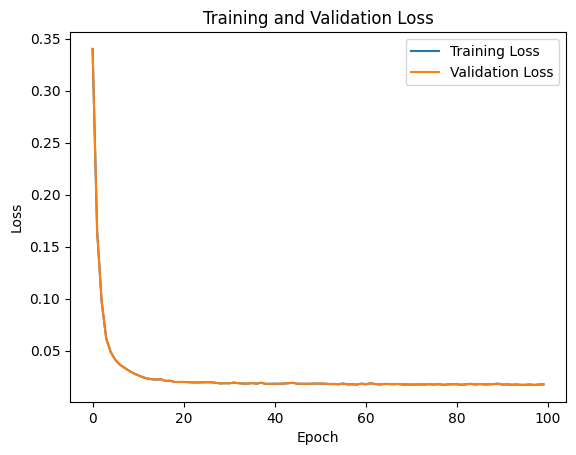

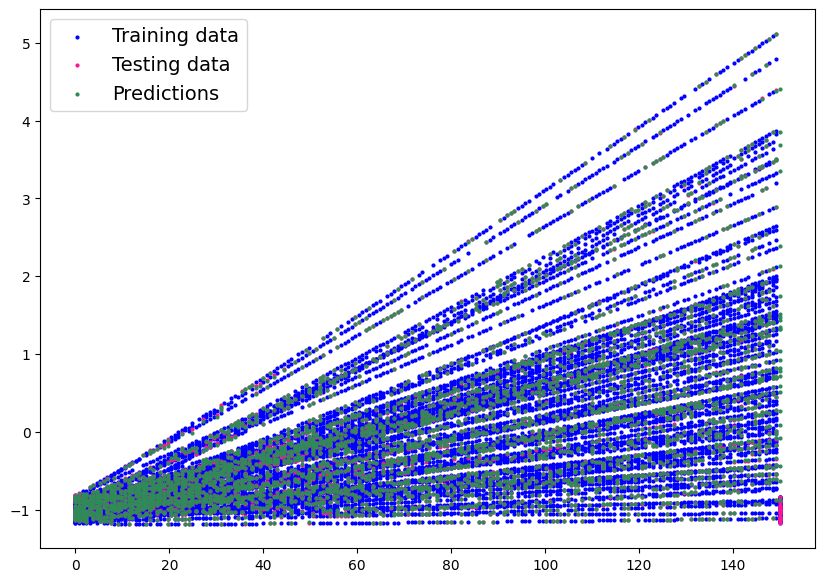

In [1]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import joblib
import pathlib as path
import copy
import modularNN as mnn

### Static
rawData = pd.read_csv('STEMVisualsSynthData.csv', header=0)
#remove unneeded column
rawData.drop('Index_within_Experiment', axis = 1, inplace = True)
#X is inputs--the three Concentrations, F_in, I0 (light intensity), and c_N_in (6)
X = rawData[['Time', 'C_X', 'C_N', 'C_L', 'F_in', 'C_N_in', 'I0']]
Y = X.copy(deep=True)
#drop unnecessary rows in Y
Y.drop('F_in', axis = 1, inplace = True)
Y.drop('C_N_in', axis = 1, inplace = True)
Y.drop('I0', axis = 1, inplace = True)
Y.drop('Time', axis = 1, inplace = True)
#Y vals should be X concentrations one timestep ahead, so remove the first index
Y.drop(index=0, inplace=True)
#To keep the two consistent, remove the last index of X
X.drop(index=19999, inplace=True)

#user defined parameters: current values can serve as a default
#splits - expects 3 floats that add to 1
trainSplit = 0.6
valSplit = 0.2
testSplit = 0.2
#model params
initNeuronNum = 18 #number of neurons in the first layer, 0 < int < 100
loss = 1 #0 = MSE, 1 = MAE
optimizer = 0 #0 = Adam, 1 = SGD
learnRate = 0.001 #0 < float < 0.1
#training params
epochs = 100 #0 < int < 1000
batchSize = 100 #0 < int < 1000

#split the data
X_train, X_val, X_test, Y_train, Y_val, Y_test, XTrainTime, XValTime, XTestTime = mnn.dataSplitter(X, Y, trainSplit, valSplit, testSplit)
#scale the data
stScalerX, stScalerY, X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled= mnn.scaleData(X_train, X_val, X_test, Y_train, Y_val, Y_test)
#tensorize the data
X_train_tensor, X_val_tensor, X_test_tensor, Y_train_tensor, Y_val_tensor, Y_test_tensor = mnn.tensors(X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled)
#create the model
model, lossFunction, optimizer = mnn.modelCreator(initNeuronNum, loss, optimizer, learnRate)
#train the model
model, trainLoss, valLoss = mnn.trainModel(model, lossFunction, optimizer, epochs, batchSize, X_train_tensor, X_val_tensor, Y_train_tensor, Y_val_tensor)
#test the model
testLoss = mnn.testModel(model, lossFunction, X_test_tensor, Y_test_tensor)
#plot the results
mnn.plotter(trainLoss, valLoss)
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  y_preds = model(X_test_tensor)
mnn.plot_predictions(train_data=XTrainTime, 
                     train_labels=Y_train_tensor[:, 1], 
                     test_data=XTestTime, 
                     test_labels=Y_test_tensor[:, 1], 
                     predictions= torch.Tensor.cpu(y_preds[:, 1]))
#save the model
mnn.saveModel(model, stScalerX, stScalerY)
#TODO: save the model, scalers, and parameters to a file
#TODO: move this to a ipynb file for easy running/visualization